In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import balanced_accuracy_score
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

# !pip install torchvision
import torchvision

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# !pip install torchmetrics
import torchmetrics

In [21]:
df_images = pd.read_csv("image class.csv")[['image_name','class']]
df_images

,image_name,class
0,Cardboard_1.jpg,Cardboard
1,Cardboard_10.jpg,Cardboard
2,Cardboard_100.jpg,Cardboard
3,Cardboard_101.jpg,Cardboard
4,Cardboard_102.jpg,Cardboard
...,...,...
4747,Vegetation_95.jpg,Vegetation
4748,Vegetation_96.jpg,Vegetation
4749,Vegetation_97.jpg,Vegetation
4750,Vegetation_98.jpg,Vegetation


In [22]:
df_images['class'].value_counts()

class
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
Name: count, dtype: int64

In [23]:
class_names = df_images['class'].unique()
class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}

df_images['label'] = df_images['class'].map(class_to_idx)

num_classes = len(class_names)

print(class_to_idx)


{'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}


In [24]:
df_images

,image_name,class,label
0,Cardboard_1.jpg,Cardboard,0
1,Cardboard_10.jpg,Cardboard,0
2,Cardboard_100.jpg,Cardboard,0
3,Cardboard_101.jpg,Cardboard,0
4,Cardboard_102.jpg,Cardboard,0
...,...,...,...
4747,Vegetation_95.jpg,Vegetation,8
4748,Vegetation_96.jpg,Vegetation,8
4749,Vegetation_97.jpg,Vegetation,8
4750,Vegetation_98.jpg,Vegetation,8


In [25]:
train_df, test_df = train_test_split(df_images, test_size=0.2, stratify=df_images['class'])

In [26]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Make all images same size
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])


In [27]:
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.loc[idx, 'image_name']
        label = self.dataframe.loc[idx, 'label']

        img_path = os.path.join(self.image_folder, img_name)

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = CustomImageDataset(
    train_df,
    image_folder="all_images",
    transform=transform
)

test_dataset = CustomImageDataset(
    test_df,
    image_folder="all_images",
    transform=transform
)
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

for images, labels in test_loader:
    print(images.shape)
    print(labels.shape)
    break

    

torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])


In [28]:
train_dataset.__len__(), test_dataset.__len__()

(3801, 951)

torch.Size([32, 3, 128, 128])


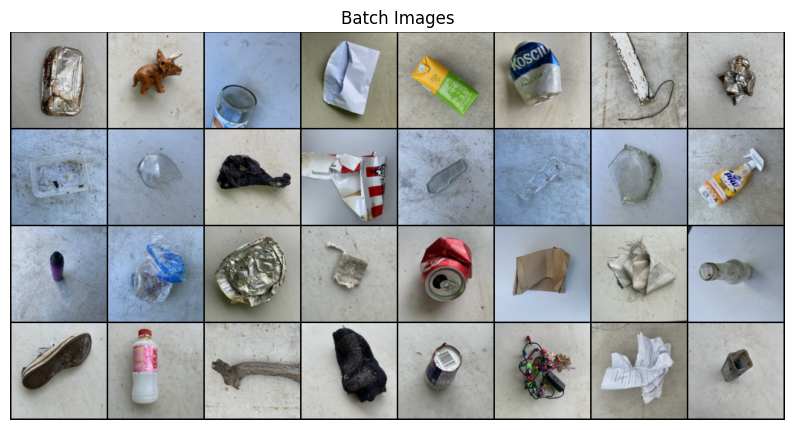

In [29]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
images, labels = next(iter(train_loader))

print(images.shape)  
transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
images = images * 0.5 + 0.5
grid = torchvision.utils.make_grid(images, nrow=8)
npimg = grid.numpy()
plt.figure(figsize=(10, 8))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis("off")
plt.title("Batch Images")
plt.show()


In [30]:
num_classes = len(class_to_idx)
print(num_classes)


9


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # Convolution Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution Block 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Convolution Block 3
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully Connected
        self.fc1 = nn.Linear(128 * 16 * 16, 256)   # adjust based on image size
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.leaky_relu(self.conv1(x)))
        x = self.pool2(F.leaky_relu(self.conv2(x)))
        x = self.pool3(F.leaky_relu(self.conv3(x)))

        x = torch.flatten(x, start_dim=1)

        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)

        return x

model = CNN(num_classes)
x = torch.randn(1, 3, 128, 128)
out = model(x)
print(out.shape)


torch.Size([1, 9])


In [33]:
print(CNN(num_classes))


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=9, bias=True)
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_loss = {}

num_epochs = 10
print("Lets start")
for epoch in range(num_epochs):
    print(f'Epoch no. {epoch}')
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    epoch_loss[epoch] = running_loss/len(train_loader)


Using device: cuda
Lets start
Epoch no. 0
Epoch [1/25], Loss: 1.4865
Epoch no. 1
Epoch [2/25], Loss: 0.9824
Epoch no. 2
Epoch [3/25], Loss: 0.7231
Epoch no. 3
Epoch [4/25], Loss: 0.5090
Epoch no. 4
Epoch [5/25], Loss: 0.3385
Epoch no. 5
Epoch [6/25], Loss: 0.2282
Epoch no. 6
Epoch [7/25], Loss: 0.1189
Epoch no. 7
Epoch [8/25], Loss: 0.0954
Epoch no. 8
Epoch [9/25], Loss: 0.0859
Epoch no. 9
Epoch [10/25], Loss: 0.0468
Epoch no. 10
Epoch [11/25], Loss: 0.0882
Epoch no. 11
Epoch [12/25], Loss: 0.0380
Epoch no. 12
Epoch [13/25], Loss: 0.0175
Epoch no. 13
Epoch [14/25], Loss: 0.0231
Epoch no. 14
Epoch [15/25], Loss: 0.0514
Epoch no. 15
Epoch [16/25], Loss: 0.0548
Epoch no. 16
Epoch [17/25], Loss: 0.0350
Epoch no. 17
Epoch [18/25], Loss: 0.0784
Epoch no. 18
Epoch [19/25], Loss: 0.0284
Epoch no. 19
Epoch [20/25], Loss: 0.0210
Epoch no. 20
Epoch [21/25], Loss: 0.0144
Epoch no. 21
Epoch [22/25], Loss: 0.0020
Epoch no. 22
Epoch [23/25], Loss: 0.0003
Epoch no. 23
Epoch [24/25], Loss: 0.0001
Epoch

In [19]:
print(epoch_loss.values())

dict_values([1.486450513871778, 0.9824357493584898, 0.7231483719929928, 0.5089506245210391, 0.3384944147297314, 0.22815053465486573, 0.11886545498424969, 0.0954332465125921, 0.0858889693969532, 0.046787584583008926, 0.08823251037881906, 0.03802557088025775, 0.017547034258619656, 0.023065981383243686, 0.05139082927695092, 0.05481828172385943, 0.03497573917270873, 0.07842363519819077, 0.02837216169152706, 0.021017762496671248, 0.014356225369898739, 0.0020318362613358024, 0.0002659838759763941, 0.0001277945771222267, 9.50434238550487e-05])


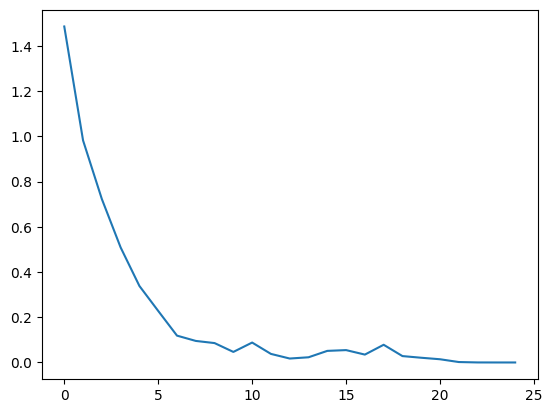

In [18]:
plt.plot(epoch_loss.keys(),epoch_loss.values())

In [15]:
model.eval()  # evaluation mode

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 72.45%


                     precision    recall  f1-score   support

          Cardboard       0.74      0.70      0.72        92
      Food Organics       0.85      0.84      0.85        82
              Glass       0.80      0.81      0.80        84
              Metal       0.70      0.78      0.74       158
Miscellaneous Trash       0.57      0.51      0.54        99
              Paper       0.80      0.65      0.72       100
            Plastic       0.69      0.77      0.72       185
      Textile Trash       0.57      0.47      0.51        64
         Vegetation       0.83      0.89      0.86        87

           accuracy                           0.72       951
          macro avg       0.73      0.71      0.72       951
       weighted avg       0.72      0.72      0.72       951



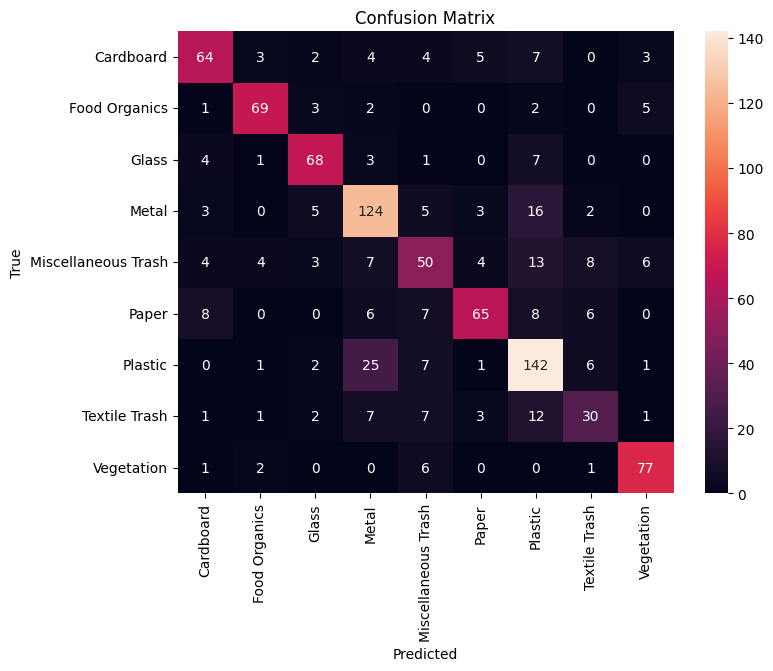

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_loss = {}

num_epochs = 10
print("Lets start")
for epoch in range(num_epochs):
    print(f'Epoch no. {epoch}')
    model.train() # train mode
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
     
    # Training Loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    epoch_loss[epoch] = running_loss/len(train_loader)
    # Testing Accuracy
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Balanced Classification Accuracy: {balanced_accuracy_score(all_labels, all_preds):.2f}")


Using device: cuda
Lets start
Epoch no. 0
Epoch [1/10], Loss: 1.5062
Test Balanced Classification Accuracy: 0.54%
Epoch no. 1
Epoch [2/10], Loss: 1.0073
Test Balanced Classification Accuracy: 0.62%
Epoch no. 2
Epoch [3/10], Loss: 0.7589
Test Balanced Classification Accuracy: 0.67%
Epoch no. 3
Epoch [4/10], Loss: 0.5596
Test Balanced Classification Accuracy: 0.66%
Epoch no. 4
Epoch [5/10], Loss: 0.4177
Test Balanced Classification Accuracy: 0.72%
Epoch no. 5
Epoch [6/10], Loss: 0.2615
Test Balanced Classification Accuracy: 0.70%
Epoch no. 6
Epoch [7/10], Loss: 0.1270
Test Balanced Classification Accuracy: 0.68%
Epoch no. 7
Epoch [8/10], Loss: 0.0838
Test Balanced Classification Accuracy: 0.73%
Epoch no. 8
Epoch [9/10], Loss: 0.0866
Test Balanced Classification Accuracy: 0.71%
Epoch no. 9
Epoch [10/10], Loss: 0.0540
Test Balanced Classification Accuracy: 0.71%
